In [66]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
plt.style.use('dark_background')
print("Setup Complete")

/bin/bash: 1.23.0: No such file or directory
Setup Complete


In [67]:
df = pd.read_csv("/kaggle/input/playground-series-s3e21/sample_submission.csv",index_col="id")
df.head()

,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
id,,,,,,,,,,,,,,,,,,,,,
0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,0.200,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,1.027,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,0.270,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,0.435,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


# EDA

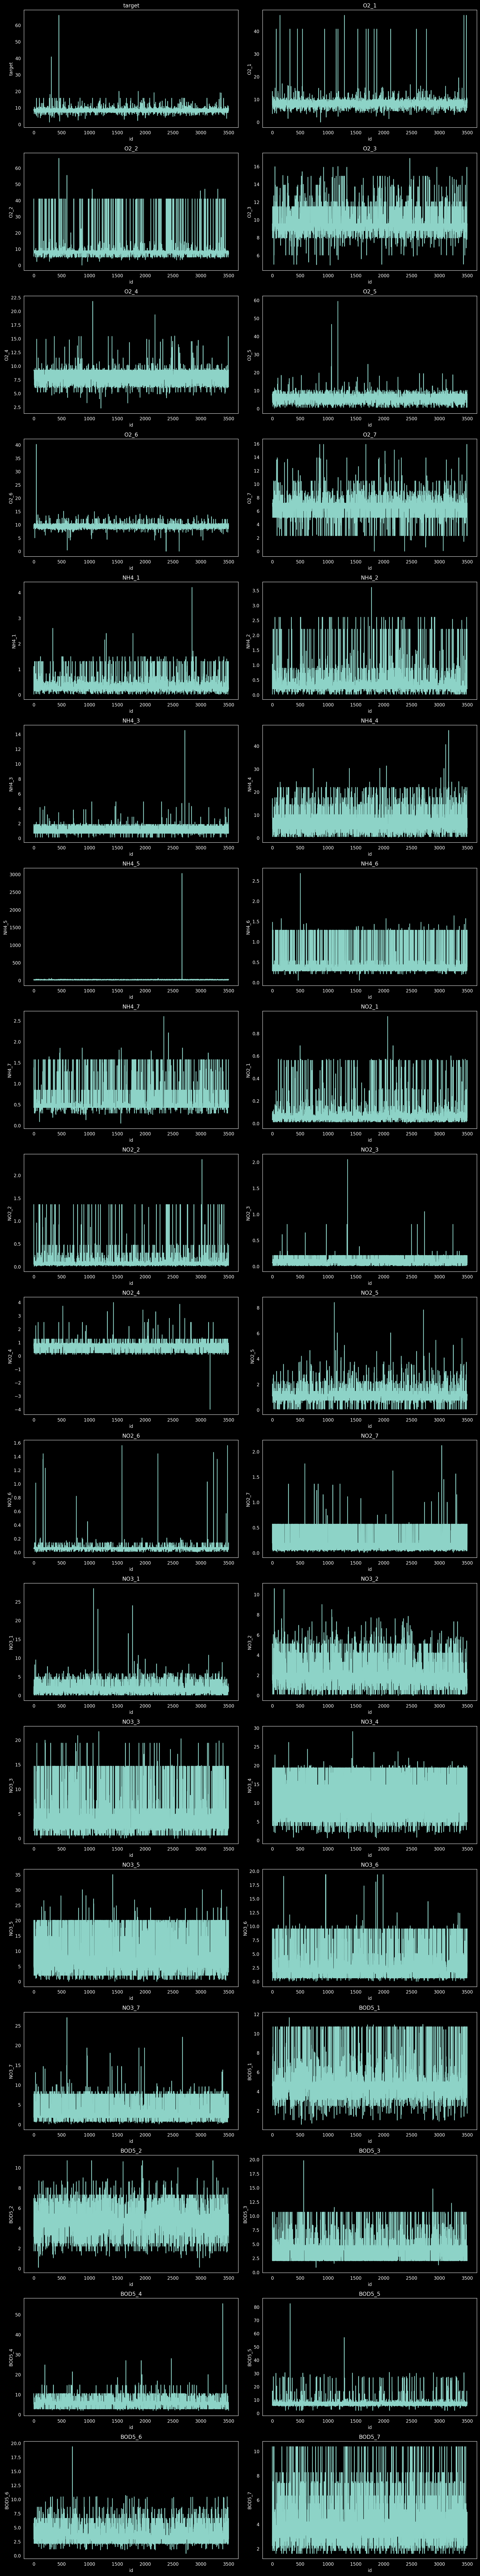

In [68]:
fig, axes = plt.subplots(18,2,figsize=(15, 80),dpi=200)
j=0
for i in df.columns:
    plt.subplot(18,2,j+1)
    sns.lineplot(df[i],palette="flare");
    plt.gca().set_title(i)
    j+=1
    
fig.tight_layout()
plt.show()


---

# Baseline

In [69]:
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [80]:
history = pd.DataFrame()
def plotImportance(model):
    history["cols"] = X_test.columns
    history["imp"] = model.feature_importances_
    history.sort_values("imp",inplace=True)
    plt.figure(figsize=(15,8))
    sns.barplot(x=history["imp"],y=history["cols"],palette="rocket");

In [71]:
cols = [i for i in df.columns if i!="target"]
seed = np.random.seed(6)

df_base = df.copy()

X = df_base[cols]
y = df_base["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,random_state=seed)

MAE is  0.7796737092007457
RMSE is  1.3196502631828075
CV score is  1.3994188448991338


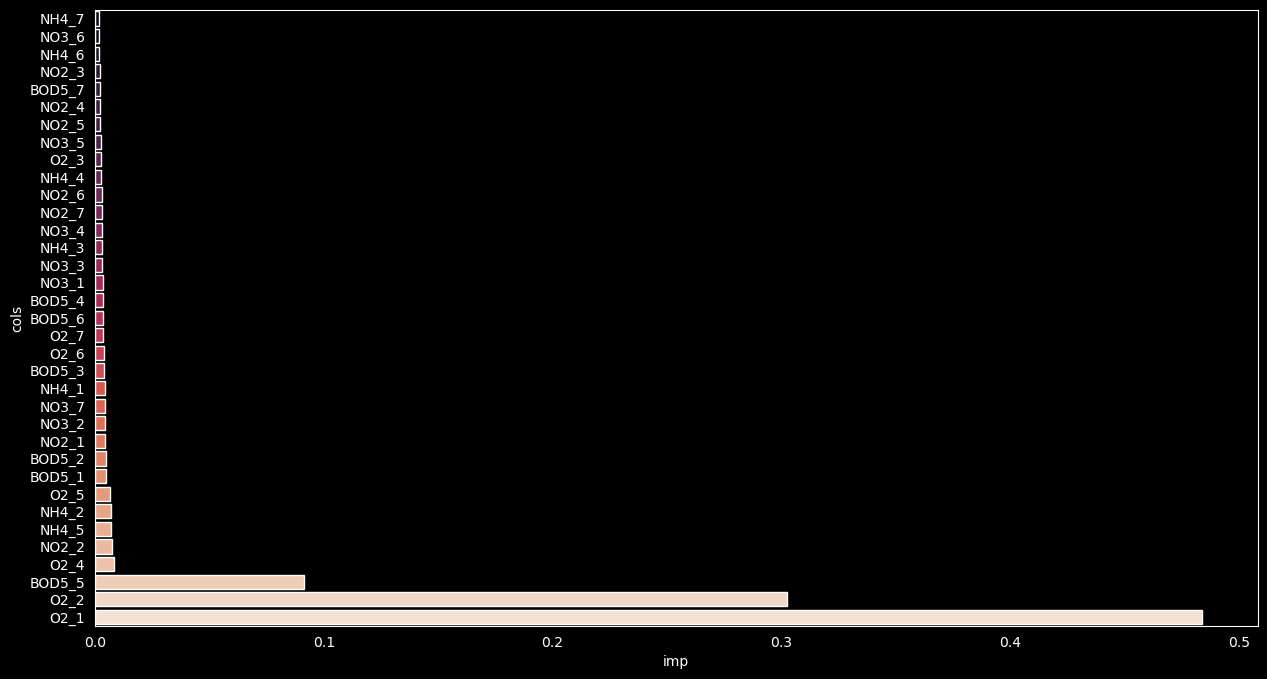

In [72]:
rfmodel = RandomForestRegressor(n_estimators=1000,max_depth=7,n_jobs=-1,random_state=42)
rfmodel.fit(X_train,y_train)
print("MAE is ",mean_absolute_error(y_test,rfmodel.predict(X_test)))
print("RMSE is ",mean_squared_error(y_test,rfmodel.predict(X_test),squared=False))
print("CV score is ",-cross_val_score(rfmodel,X,y,cv=5, scoring = 'neg_root_mean_squared_error').mean())
plotImportance(rfmodel)

---

# Removing Outliers

In [73]:
df_outliers = df[df["target"]<22]
df_describe = df_outliers.describe()
df_describe

,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
count,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,...,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000
mean,8.448173,8.198292,9.266347,9.633208,8.066506,5.671960,9.461875,6.547408,0.340377,0.397899,...,8.710415,3.002170,3.242736,4.816928,4.754779,4.285431,5.969034,7.837984,3.750528,4.068695
std,1.521453,2.939253,6.730896,1.439436,1.463941,2.722131,1.140480,1.663733,0.284753,0.452353,...,6.440444,2.918996,2.714513,2.009699,1.547787,2.093964,2.576879,3.725330,1.682857,1.895168
min,1.300000,0.000000,0.000000,4.900000,2.300000,0.200000,0.000000,0.000000,0.020000,0.020000,...,0.044000,0.011000,0.000000,0.570000,0.089000,0.850000,2.025000,2.020000,0.364000,1.600000
25%,7.470000,7.100000,7.300000,8.770000,6.856250,4.550000,8.980000,5.852500,0.213500,0.200000,...,4.450000,1.140000,1.780000,3.520000,3.950000,2.290000,4.950000,5.725000,2.652000,2.900000
50%,8.280000,7.880000,8.300000,9.500000,7.980000,5.800000,9.430000,6.430000,0.247000,0.245000,...,6.054000,1.730000,1.800000,4.600000,4.800000,3.950000,5.725000,7.500000,3.500000,3.700000
75%,9.110000,9.100000,8.700000,9.545000,9.265000,7.015000,10.070000,7.150000,0.370000,0.405000,...,14.515000,3.025000,4.215000,5.000000,5.400000,4.725000,6.250000,8.400000,4.150000,4.450000
max,19.950000,46.950000,55.450000,16.900000,21.800000,59.400000,40.190000,15.900000,4.200000,3.600000,...,35.000000,19.355000,27.025000,11.650000,10.700000,19.800000,55.400000,82.450000,19.375000,10.370000


In [74]:
cols = df_outliers.columns

for i in cols[1:]:
    Q1 = df_describe[i]["25%"]
    Q3 = df_describe[i]["75%"]
    df_outliers[i][df_outliers[i]<Q1] = Q1
    df_outliers[i][df_outliers[i]>Q3] = Q3

In [75]:
df_outliers.describe()

,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
count,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,...,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000
mean,8.448173,8.029189,8.094130,9.265260,8.137860,5.692719,9.490917,6.596999,0.279512,0.280039,...,8.157036,2.049930,2.559950,4.382468,4.714734,3.791085,5.647741,7.233496,3.386715,3.657619
std,1.521453,0.833887,0.576464,0.335299,1.015361,0.957911,0.499796,0.549415,0.062627,0.084253,...,4.087059,0.735799,1.067301,0.602984,0.593851,1.004019,0.550927,1.120546,0.588354,0.655449
min,1.300000,7.100000,7.300000,8.770000,6.856250,4.550000,8.980000,5.852500,0.213500,0.200000,...,4.450000,1.140000,1.780000,3.520000,3.950000,2.290000,4.950000,5.725000,2.652000,2.900000
25%,7.470000,7.100000,7.300000,8.770000,6.860937,4.550000,8.980000,5.861875,0.213875,0.200000,...,4.450000,1.140000,1.780000,3.520000,3.950000,2.290000,4.950000,5.725000,2.664000,2.900000
50%,8.280000,7.880000,8.300000,9.500000,7.980000,5.800000,9.430000,6.430000,0.247000,0.245000,...,6.054000,1.730000,1.800000,4.600000,4.800000,3.950000,5.725000,7.500000,3.500000,3.700000
75%,9.110000,9.100000,8.700000,9.545000,9.265000,7.015000,10.070000,7.150000,0.370000,0.405000,...,14.515000,3.025000,4.203750,5.000000,5.400000,4.725000,6.250000,8.400000,4.150000,4.450000
max,19.950000,9.100000,8.700000,9.545000,9.265000,7.015000,10.070000,7.150000,0.370000,0.405000,...,14.515000,3.025000,4.215000,5.000000,5.400000,4.725000,6.250000,8.400000,4.150000,4.450000


In [76]:
df_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3498 entries, 0 to 3499
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  3498 non-null   float64
 1   O2_1    3498 non-null   float64
 2   O2_2    3498 non-null   float64
 3   O2_3    3498 non-null   float64
 4   O2_4    3498 non-null   float64
 5   O2_5    3498 non-null   float64
 6   O2_6    3498 non-null   float64
 7   O2_7    3498 non-null   float64
 8   NH4_1   3498 non-null   float64
 9   NH4_2   3498 non-null   float64
 10  NH4_3   3498 non-null   float64
 11  NH4_4   3498 non-null   float64
 12  NH4_5   3498 non-null   float64
 13  NH4_6   3498 non-null   float64
 14  NH4_7   3498 non-null   float64
 15  NO2_1   3498 non-null   float64
 16  NO2_2   3498 non-null   float64
 17  NO2_3   3498 non-null   float64
 18  NO2_4   3498 non-null   float64
 19  NO2_5   3498 non-null   float64
 20  NO2_6   3498 non-null   float64
 21  NO2_7   3498 non-null   float64
 22  

In [77]:
cols = [i for i in df.columns if i!="target"]
seed = np.random.seed(6)

X = df_outliers[cols]
y = df_outliers["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,random_state=seed)

MAE is  0.8070676420865348
RMSE is  1.2299355291440155
CV score is  1.2421941560843504


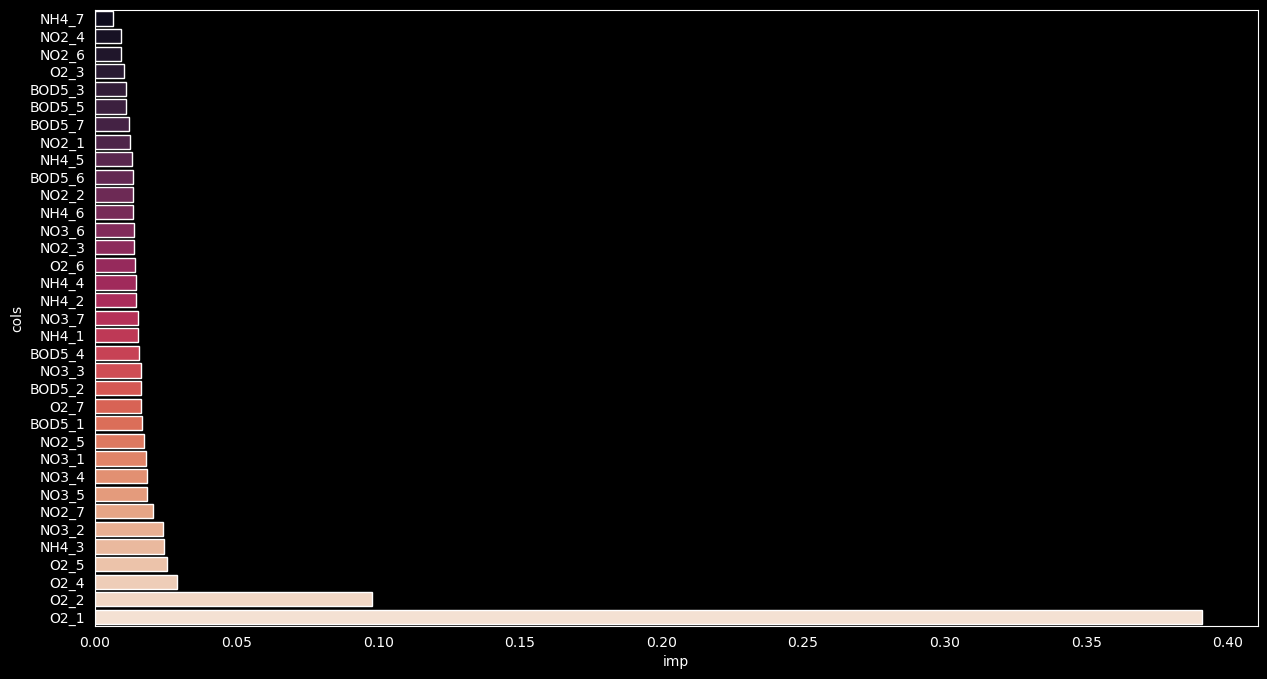

In [81]:
rfmodel = RandomForestRegressor(n_estimators=1000,max_depth=7,n_jobs=-1,random_state=42)
rfmodel.fit(X_train,y_train)
print("MAE is ",mean_absolute_error(y_test,rfmodel.predict(X_test)))
print("RMSE is ",mean_squared_error(y_test,rfmodel.predict(X_test),squared=False))
print("CV score is ",-cross_val_score(rfmodel,X,y,cv=5, scoring = 'neg_root_mean_squared_error').mean())
plotImportance(rfmodel)

---

# Feature Selection

In [86]:
history.sort_values("imp",ascending=False,inplace=True)

In [108]:
final_cols = list(history["cols"][0:4])
prev_cv_score = 10

for i in range(5,20):
    cols = history["cols"][0:i]
    
    X = df_outliers[cols]
    y = df_outliers["target"]

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,random_state=seed)
    rfmodel.fit(X_train,y_train)
    print("-"*50)
    print(list(cols))
    print("MAE is ",mean_absolute_error(y_test,rfmodel.predict(X_test)))
    print("RMSE is ",mean_squared_error(y_test,rfmodel.predict(X_test),squared=False))
    cv_score = -cross_val_score(rfmodel,X,y,cv=5, scoring = 'neg_root_mean_squared_error').mean()
    print("CV score is ",cv_score)
    print()
    if cv_score<prev_cv_score:
        final_cols.append(list(cols)[i-1])
    prev_cv_score = cv_score
print("Selected Columns:", final_cols)

--------------------------------------------------
['O2_1', 'O2_2', 'O2_4', 'O2_5', 'NH4_3']
MAE is  0.8921816651956918
RMSE is  1.367234906873847
CV score is  1.2625872444517803

--------------------------------------------------
['O2_1', 'O2_2', 'O2_4', 'O2_5', 'NH4_3', 'NO3_2']
MAE is  0.8018432739716878
RMSE is  1.2113410594702267
CV score is  1.2602840098527968

--------------------------------------------------
['O2_1', 'O2_2', 'O2_4', 'O2_5', 'NH4_3', 'NO3_2', 'NO2_7']
MAE is  0.8217677523680783
RMSE is  1.2319562314340602
CV score is  1.2525558841787112

--------------------------------------------------
['O2_1', 'O2_2', 'O2_4', 'O2_5', 'NH4_3', 'NO3_2', 'NO2_7', 'NO3_5']
MAE is  0.892119698913086
RMSE is  1.4218823982914852
CV score is  1.24925756360638

--------------------------------------------------
['O2_1', 'O2_2', 'O2_4', 'O2_5', 'NH4_3', 'NO3_2', 'NO2_7', 'NO3_5', 'NO3_4']
MAE is  0.7923458014330144
RMSE is  1.2654271476231809
CV score is  1.2496366652513786

---------

In [109]:
X = df_outliers[final_cols]
y = df_outliers["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,random_state=seed)
rfmodel.fit(X_train,y_train)
print("-"*50)
print(list(cols))
print("MAE is ",mean_absolute_error(y_test,rfmodel.predict(X_test)))
print("RMSE is ",mean_squared_error(y_test,rfmodel.predict(X_test),squared=False))
cv_score = -cross_val_score(rfmodel,X,y,cv=5, scoring = 'neg_root_mean_squared_error').mean()
print("CV score is ",cv_score)

--------------------------------------------------
['O2_1', 'O2_2', 'O2_4', 'O2_5', 'NH4_3', 'NO3_2', 'NO2_7', 'NO3_5', 'NO3_4', 'NO3_1', 'NO2_5', 'BOD5_1', 'O2_7', 'BOD5_2', 'NO3_3', 'BOD5_4', 'NH4_1', 'NO3_7', 'NH4_2']
MAE is  0.7609420905006102
RMSE is  1.0303440652624314
CV score is  1.2390977686200615


In [116]:
# final_cols = ['O2_1', 'O2_2', 'O2_4', 'O2_5', 'NH4_3', 'NO3_2', 'NO2_7', 'NO3_5', 'NO3_4', 'NO3_1', 'NO2_5', 'BOD5_1', 'O2_7', 'BOD5_2', 'NO3_3', 'BOD5_4', 'NH4_1', 'NO3_7', 'NH4_2']
final_cols.append("target")

In [117]:
df_submission = df.copy()
for i in df_submission.columns:
    if i not in final_cols:
        df_submission[i]=0
df_submission.head()

,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
id,,,,,,,,,,,,,,,,,,,,,
0,8.59,7.500,9.00,0,9.265,8.110,0,7.15,0.180,0.200,...,4.95,0,1.800,4.800,3.15,0,10.465,0,0,0
1,9.10,13.533,40.90,0,9.265,6.015,0,7.15,1.107,1.027,...,20.05,0,7.695,4.550,6.95,0,5.200,0,0,0
2,8.21,3.710,5.42,0,9.265,4.550,0,7.15,0.020,0.020,...,4.58,0,3.960,4.935,4.95,0,6.075,0,0,0
3,8.39,8.700,8.10,0,9.200,5.200,0,6.67,0.280,0.270,...,8.45,0,1.730,6.300,4.70,0,6.200,0,0,0
4,8.07,8.050,8.65,0,9.265,3.290,0,7.15,0.360,0.435,...,2.02,0,0.760,4.800,4.97,0,2.800,0,0,0


In [118]:
df_submission.to_csv("submission.csv",header=True,index=True)